In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import sys, os
import itertools

%matplotlib inline

In [2]:
N = 500
view_radius = 10

In [3]:
def create_with_fn(f):
    array = np.zeros((N,N))
    for x in range(N):
        for y in range(N):
            phi = x * 2 * pi / N
            theta = y * 2 * pi / N
            array[x][y] = f(phi, theta)
    return array

def normalize(angle):
    angle %= 2 * pi
    angle += 2 * pi
    angle %= 2 * pi
    return angle

def angle_to_index(angle):
    angle = normalize(angle)
    return angle / (2 * pi) * N

def anglediff(a, b):
    d = a - b
    d = normalize(d)
    if 0 <= d <= pi:
        return d
    else:
        return 2 * pi - d

In [4]:
class PhiTheta:
    def __init__(self, f):
        """Accepts a function of type [phi, theta] -> float"""
        if callable(f):
            self.__array = create_with_fn(f)
        else:
            self.__array = f
    def cos(self):
        return PhiTheta(np.cos(self.__array))
    def abs(self):
        return PhiTheta(np.abs(self.__array))
    def __add__(self, other):
        return PhiTheta(self.__array + other.__array)
    def __sub__(self, other):
        return PhiTheta(self.__array - other.__array)
    def __call__(self, phi, theta):
        return self.__array[angle_to_index(phi), angle_to_index(theta)]
    def __getitem__(self, xy):
        return self.__array[xy]
    @property
    def array(self):
        return self.__array

In [5]:
theta = PhiTheta(lambda _, theta : theta)
phi = PhiTheta(lambda phi, _ : phi)

cos_theta_m_phi = (theta - phi).cos()
L0 = cos_theta_m_phi.abs() + cos_theta_m_phi

In [6]:
def calculate_escape(transparency_unreg, n):
    def phi_prime(phi, theta):
        return pi - 6 * theta + 7 * phi
    def theta_prime(phi, theta):
        return pi - 10 * theta + 11 * phi
    def transparency(theta):
        return transparency_unreg(normalize(theta))
    def refl(phi, theta):
        return 1 - transparency(theta_prime(phi, theta))
    escape = np.zeros((N,N))
    L = L0
    for x in range(n):
        escape += PhiTheta(lambda phi, theta : L(phi, theta) * transparency(theta)).array
        L = PhiTheta(lambda phi, theta: L(phi_prime(phi, theta), theta_prime(phi, theta)) * refl(phi,theta))
    return escape

def get_light_pattern(escape):
    values = np.zeros((N,N))
    for i, j in itertools.product(range(N), range(N)):
        x = (i / N - 0.5) * view_radius
        y = (j / N - 0.5) * view_radius
        r = np.sqrt(x*x + y*y)
        if r < 1:
            continue
        alpha = np.arctan2(y,x)
        diff = np.arcsin(1/r)
        for u in range(N):
            phi = u * 2 * pi / N
            if anglediff(phi, alpha) < diff*0.99:
                values[-j,i] += escape[angle_to_index(phi), angle_to_index(phi + np.arcsin(r * np.sin(alpha - phi)))]
    return values

def plot_2d(array, file=""):
    plt.axis('off')
    fig = plt.imshow(array)
    fig.set_cmap('spectral')
    if file:
        if not os.path.exists("img"):
            os.makedirs("img")
        file = "img/" + file
        plt.savefig(file, bbox_inches='tight', dpi=250)

def porus_mirror(transparency_unreg, n, file=""):
    escape = calculate_escape(transparency_unreg, n)
    plot_2d(escape, file=file + "-phitheta.png")
    plt.show()
    light_pattern = get_light_pattern(escape)
    plot_2d(light_pattern, file=file + "-pattern.png")

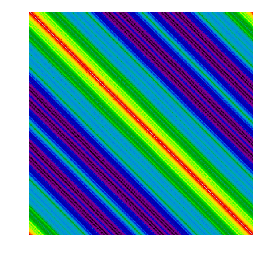

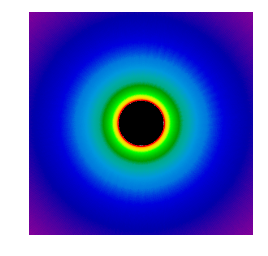

In [7]:
porus_mirror(lambda theta: 0.5, 10, "const")

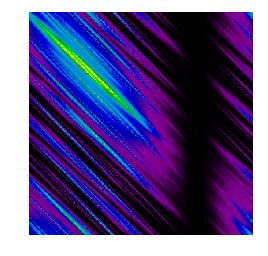

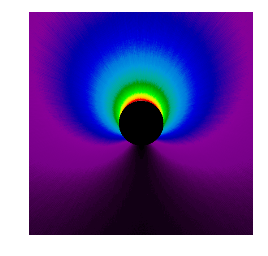

In [8]:
porus_mirror(lambda theta: (np.sin(theta) + 1)/2, 20, "sin_shift")

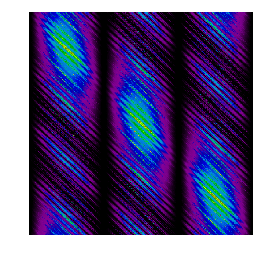

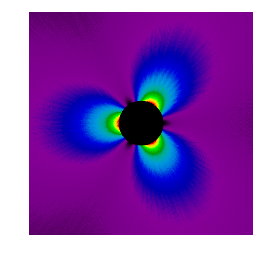

In [9]:
porus_mirror(lambda theta: np.sin(3/2 * theta) ** 2, 20, "sin_3")

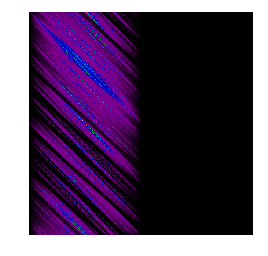

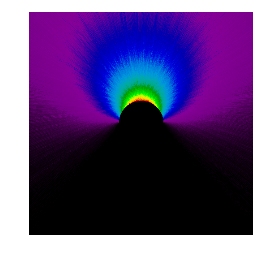

In [10]:
porus_mirror(lambda theta: (np.sin(theta) + np.abs(np.sin(theta))) / 2, 20, "half_opaque")

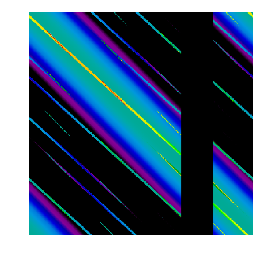

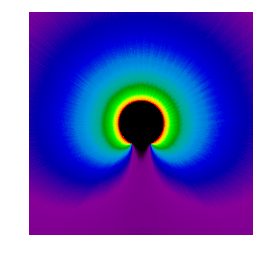

In [11]:
porus_mirror(lambda theta: (1 + np.sign(np.sin(theta) + 0.9)) / 2, 7, "small_refl")

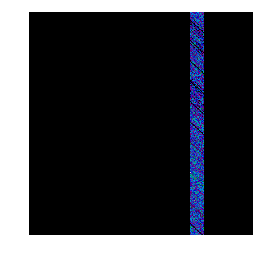

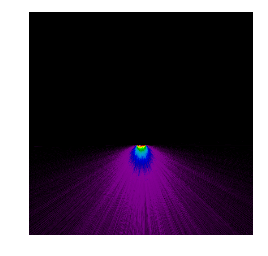

In [12]:
porus_mirror(lambda theta: (1 - np.sign(np.sin(theta) + 0.98)) / 2, 20, "small_slit")

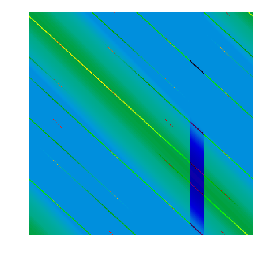

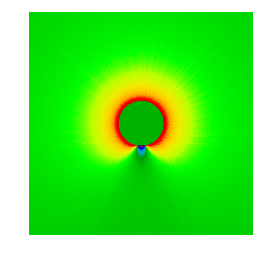

In [13]:
porus_mirror(lambda theta: np.sign(np.sin(theta) + 0.98), 20, "negative_slit")

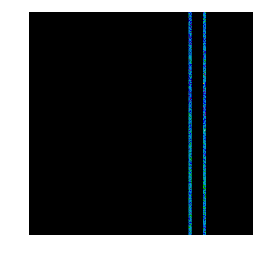

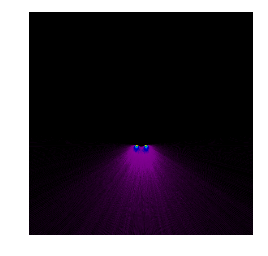

In [14]:
porus_mirror(lambda theta: (2 - np.sign(np.sin(theta - pi/16) + 0.999) - np.sign(np.sin(theta + pi/16) + 0.999)) / 4, 20, "double_slit")

In [ ]:
porus_mirror(lambda theta: (2 - np.sign(np.sin(theta - pi/16) + 0.999) + np.sign(np.sin(theta + pi/16) - 0.999)) / 4, 20, "posneg_slit")